## 1. import libraries & Data ##

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.stats.api import *
from sklearn.preprocessing import * 
import time
import itertools 

In [2]:
# import data #
df_raw = pd.read_csv("./Fish.csv")
df = df_raw
df.info() # 159행 7열

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


## 2. EDA / Preprocess ##

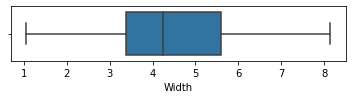

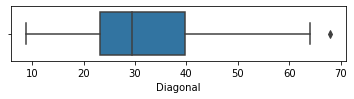

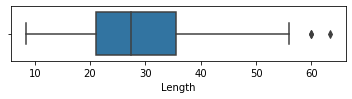

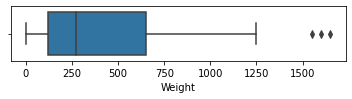

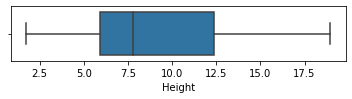

In [3]:
# View Data (Boxplot) (From 민성님 코드) #
fac_col = df.select_dtypes("object").columns.tolist()
num_col = list(set(df).difference(set(fac_col))) #df1=df.select_dtypes(exclude=['object'])
df1 = df[num_col]

for column in df1:
    plt.figure(figsize=(len(num_col)+1,1))
    sb.boxplot(data=df1, x=column)    

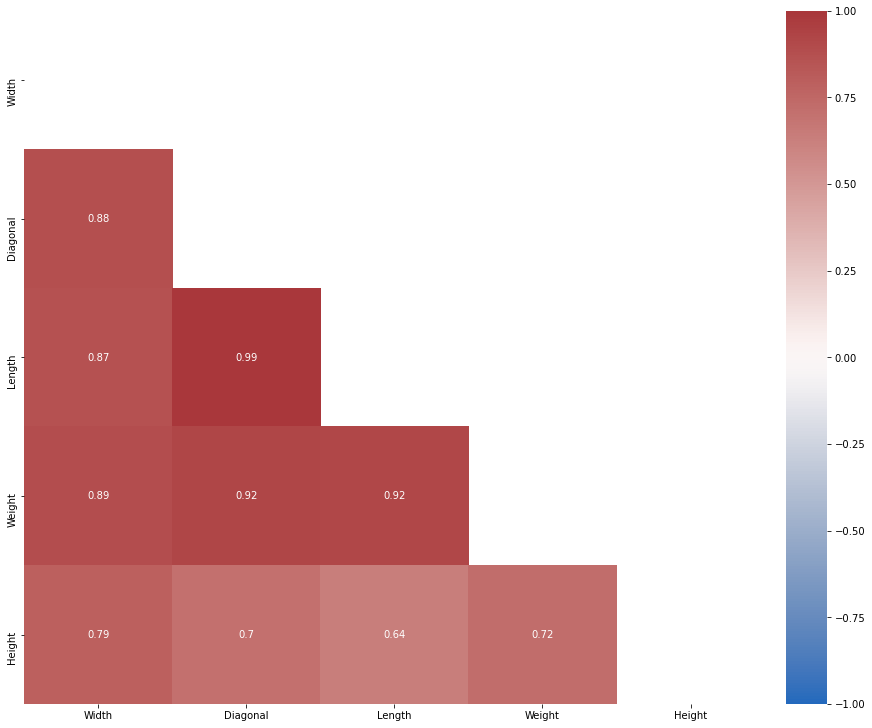

In [4]:
# View Data (Correlation Heatmap) (From 민성님 코드) #
df1_corr = df1.corr()
# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like( df1_corr, dtype=np.bool )
mask[ np.triu_indices_from( mask ) ] = True
# 히트맵 시각화
plt.figure(figsize=(12,10),
            constrained_layout = True)
sb.heatmap( df1_corr,
            annot = True,
            cmap = 'vlag',  # https://seaborn.pydata.org/tutorial/color_palettes.html
            mask = mask,
            vmin = -1, vmax = 1, center = 0)
plt.show()
print()

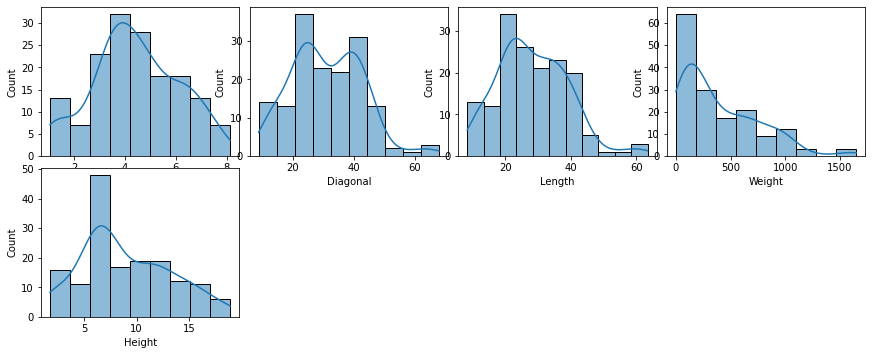

In [5]:
# View data (Histogram) #
plt.figure( figsize=(12, 18),
            constrained_layout = True)

for i in range(0, df1.columns.size ):
    plt.subplot( 8, 4, i+1 ) # 그래프 배열 n행 m열
    sb.histplot( df1.iloc[:, i], kde = True )

In [6]:
# 이상치 제거 (From 민성님 코드) #
def get_outlier_drop( df=None, outlier_columns=None, weight=1.5):

    outlier_index = list()
    df_outlier_drop = df.copy()
    
    
    for i in range(0, outlier_columns.shape[1]):  # 분류분석의 경우 'Class' 변수를 제외하고 이상치를 탐색하기 위해 범위를 조정할 필요가 있다.
                                     # 종속변수 'Class'의 경우, 분포 불균형으로 인해 1을 모두 이상치로 인식함.  
        
        # col에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
        col = outlier_columns.iloc[:,i]
        quantile_25 = col.quantile(0.25)
        quantile_75 = col.quantile(0.75)
        
        # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * weight
        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight
        
        # 최대값 보다 크거나, 최소값 보다 작은 값을 이상치로 설정하고 이상치와 해당 index를 반환.
        outlier = col[ (col < lowest_val) | (col > highest_val) ]
        
        # 이상치가 존재하는 행 index 주소를 리스트에 추가
        if len(outlier) == 0:
            pass
        else:
            outlier_index.extend( outlier.index )
            
    # 이상치가 존재하는 행을 모두 제거한 데이터프레임 생성
    df_outlier_drop = df_outlier_drop.drop( np.unique(outlier_index), axis=0 )
        
    return df_outlier_drop

df = get_outlier_drop( df = df,
                       outlier_columns = df1 )
df.info() # 156행, 7열

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   156 non-null    object 
 1   Weight    156 non-null    float64
 2   Length    156 non-null    float64
 3   Diagonal  156 non-null    float64
 4   Height    156 non-null    float64
 5   Width     156 non-null    float64
dtypes: float64(5), object(1)
memory usage: 8.5+ KB


## 3. Build Model ##

In [7]:
# One-hot encoding
y_col = ["Weight"]
x_cols = list(set(df).difference(set(y_col)))
fac_col = df[x_cols].select_dtypes("object").columns.tolist()
num_col = list(set(x_cols).difference(set(fac_col)))
for col in fac_col :
    df[col] = pd.Categorical(df[col])
x_onehot= pd.get_dummies(df)
new_x_cols = list(set(x_onehot).difference(set(y_col)))

In [8]:
# Using SM and Not using C() #
model = sm.OLS.from_formula(f"{y_col[0]}~"+"+".join(x_cols), data=df)
result = model.fit()
result.predict(df[x_cols])
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     250.4
Date:                Wed, 17 Nov 2021   Prob (F-statistic):           3.54e-86
Time:                        22:28:04   Log-Likelihood:                -893.88
No. Observations:                 156   AIC:                             1810.
Df Residuals:                     145   BIC:                             1843.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -748.1362    103.814     -7.207      0.000    -953.320    -542.952
Species[T.Parkki]       71.4008     62.028      1.151      0.252     -51.195     193.997
Species[T.Perch]       141.3366     99.090      1.426      0.156     -54.510     337.183
Species[T.Pike]        120.0694    117.837      1.019      0.310    -112.832     352.970
Species[T.Roach]       123.0872     74.796      1.646      0.102     -24.744     270.919
Species[T.Smelt]       429.3662     96.549      4.447      0.000     238.542     620.191
Species[T.Whitefish]   128.2971     79.713      1.609      0.110     -29.253     285.847
Width                   49.3941     20.662      2.391      0.018       8.557      90.231
Diagonal               -18.3444     24.931     -0.736      0.463     -67.620      30.932
Length                  33.8910     25.293      1.340      0.182     -16.099      83.881
Height                  44.7452     11.493      3.893      0.000      22.030      67.461
==============================================================================
Omnibus:                       38.107   Durbin-Watson:                   0.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.450
Skew:                           1.126   Prob(JB):                     1.85e-16
Kurtosis:                       5.464   Cond. No.                     1.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Using SM and Not using C() (No need to one-hot encode) #
df1 = df_raw
y_col = ["Weight"]
x_cols = list(set(df1).difference(set(y_col)))
fac_col = df1[x_cols].select_dtypes("object").columns.tolist()
num_col = list(set(x_cols).difference(set(fac_col)))

formula = f"{y_col[0]}~"+"+".join(num_col) + "+" + "+".join([f"C({i})"for i in fac_col])
model1 = sm.OLS.from_formula(formula, data=df1)
result1 = model1.fit()
result1.summary()
# 계수의 값이 다름

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     209.3
Date:                Wed, 17 Nov 2021   Prob (F-statistic):           5.08e-82
Time:                        22:28:04   Log-Likelihood:                -944.07
No. Observations:                 159   AIC:                             1910.
Df Residuals:                     148   BIC:                             1944.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -866.3015    126.525     -6.847      0.000   -1116.330    -616.273
C(Species)[T.Parkki]      136.9995     75.633      1.811      0.072     -12.461     286.460
C(Species)[T.Perch]       130.2884    121.838      1.069      0.287    -110.478     371.055
C(Species)[T.Pike]       -221.0977    136.955     -1.614      0.109    -491.737      49.542
C(Species)[T.Roach]        77.3647     91.754      0.843      0.400    -103.953     258.682
C(Species)[T.Smelt]       393.8699    118.611      3.321      0.001     159.480     628.260
C(Species)[T.Whitefish]    95.8948     97.919      0.979      0.329     -97.605     289.394
Width                      -4.0734     24.171     -0.169      0.866     -51.839      43.692
Height                      8.6656     13.134      0.660      0.510     -17.289      34.620
Diagonal                   32.3468     29.684      1.090      0.278     -26.312      91.005
Length                      4.0482     30.665      0.132      0.895     -56.550      64.647
==============================================================================
Omnibus:                       40.231   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.066
Skew:                           1.112   Prob(JB):                     2.05e-19
Kurtosis:                       5.837   Cond. No.                     1.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


In [11]:
## Using Scikit Learn Linear Regression ##
X = x_onehot[new_x_cols].values
y = x_onehot[y_col].values
reg = LinearRegression().fit(X, y)

## 4. Verify Model ##
### - Using SM Model ###

0.916760691429331


C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

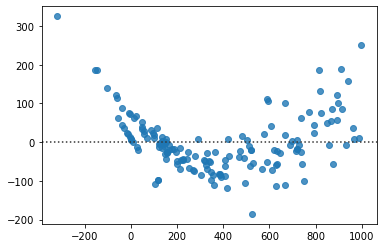

In [12]:
# Visualize Residual #
print(durbin_watson(result.resid))
sb.residplot(result.fittedvalues,result.resid)

Durbin-Watson test 값이 0에 가깝고, Residual이 2차곡선 & 오른쪽으로 갈수록 벌어지는 형태를 띔

<AxesSubplot:xlabel='Weight', ylabel='Count'>

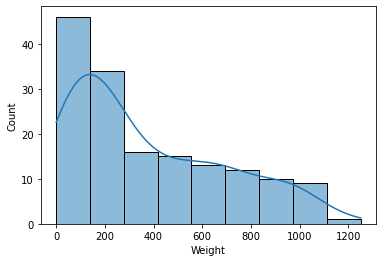

In [13]:
# y 재탐색 #
# Raw y histogram #
sb.histplot(df["Weight"], kde = True )

<AxesSubplot:xlabel='Weight', ylabel='Count'>

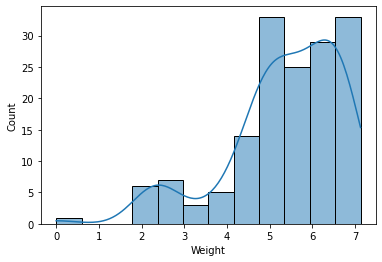

In [14]:
#log y histogram #
weight_log = np.log1p(df['Weight'])
sb.histplot(weight_log, kde = True )

<AxesSubplot:ylabel='Count'>

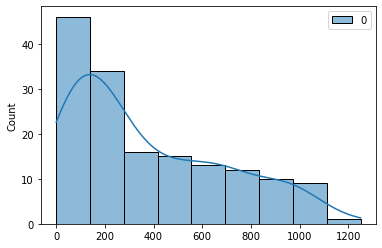

In [15]:
# Scale y histogram #
scaler = StandardScaler()
Weight_reshape = df['Weight'].values.reshape(-1,1)
sb.histplot(Weight_reshape, kde = True )

로그, 스케일링으로도 데이터를 정규화시킬 수 없고 잔차가 2차 모형을 띄는 점을 고려하여 X의 제곱 항을 추가

In [16]:
## Height 제곱항 추가 (다른 변수들과의 Cor이 그나마 적음) ##
y_col = ["Weight"]
df['HeightSquare'] = df['Height']**2
x_cols = list(set(df).difference(set(y_col)))
fac_col = df[x_cols].select_dtypes("object").columns.tolist()
num_col = list(set(x_cols).difference(set(fac_col)))
for col in fac_col :
    df[col] = pd.Categorical(df[col])
x_onehot= pd.get_dummies(df)
new_x_cols = list(set(x_onehot).difference(set(y_col)))
df1=df[num_col]

In [17]:
df

,Species,Weight,Length,Diagonal,Height,Width,HeightSquare
0,Bream,242.0,25.4,30.0,11.5200,4.0200,132.710400
1,Bream,290.0,26.3,31.2,12.4800,4.3056,155.750400
2,Bream,340.0,26.5,31.1,12.3778,4.6961,153.209933
3,Bream,363.0,29.0,33.5,12.7300,4.4555,162.052900
4,Bream,430.0,29.0,34.0,12.4440,5.1340,154.853136
...,...,...,...,...,...,...,...
154,Smelt,12.2,12.2,13.4,2.0904,1.3936,4.369772
155,Smelt,13.4,12.4,13.5,2.4300,1.2690,5.904900
156,Smelt,12.2,13.0,13.8,2.2770,1.2558,5.184729
157,Smelt,19.7,14.3,15.2,2.8728,2.0672,8.252980


In [18]:
## Build model ##
model = sm.OLS.from_formula(f"{y_col[0]}~"+"+".join(x_cols), data=df)
result_sq = model.fit()
result_sq.predict(df[x_cols])
result_sq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     336.6
Date:                Wed, 17 Nov 2021   Prob (F-statistic):           8.26e-97
Time:                        22:28:06   Log-Likelihood:                -864.25
No. Observations:                 156   AIC:                             1753.
Df Residuals:                     144   BIC:                             1789.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -294.8923    102.516     -2.877      0.005    -497.522     -92.262
Species[T.Parkki]      118.8100     51.803      2.294      0.023      16.418     221.202
Species[T.Perch]       -53.4721     85.630     -0.624      0.533    -222.726     115.782
Species[T.Pike]       -276.8288    109.226     -2.534      0.012    -492.722     -60.935
Species[T.Roach]       -41.4810     65.268     -0.636      0.526    -170.488      87.526
Species[T.Smelt]        54.3051     92.378      0.588      0.558    -128.288     236.898
Species[T.Whitefish]     5.3155     67.848      0.078      0.938    -128.792     139.423
Width                   95.5784     18.057      5.293      0.000      59.887     131.270
Diagonal                -2.0764     20.786     -0.100      0.921     -43.161      39.009
Length                  28.6208     21.000      1.363      0.175     -12.887      70.129
HeightSquare             4.1753      0.512      8.157      0.000       3.164       5.187
Height                 -95.6438     19.676     -4.861      0.000    -134.535     -56.752
==============================================================================
Omnibus:                       22.405   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.757
Skew:                           0.740   Prob(JB):                     1.72e-08
Kurtosis:                       4.820   Cond. No.                     5.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.916760691429331


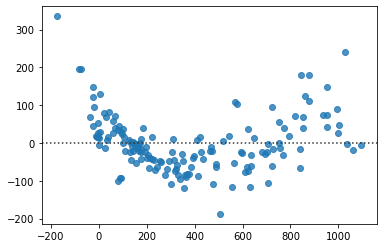

In [19]:
## 잔차 재확인 ##
sb.residplot(result_sq.fittedvalues,result.resid)
print(durbin_watson(result.resid))

Durbin-Watson값이 2에 가까워졌고, 잔차의 분포도 2차항이 흐릿해졌으나 여전히 경향이 있는 것으로 보임 -> 다른 변수의 제곱항도 넣어보기

## 5. Model Selection ##
### 전진, 후진, stepwise Selection ###

In [44]:
def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[1])
    return best_model

In [42]:
### 전진선택법(step=1)

def forward(X,y,predictors):
    
    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
### 전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [57]:
# 후진선택법 #

def backward(X,y,predictors) :
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리 정의된 predictors 조합 확인
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']
    
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Bmodels["model"].dropna().iloc[0])

In [60]:
# Stepwise model #

def Stepwise_model(X,y):
    X['const'] = np.ones([len(df.iloc[:,0]), 1])

    Stepmodels = pd.DataFrame(columns = ["AIC","model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']

    # 변수 1~10개 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1) :
        Forward_result = forward(X=X,y=y,predictors = predictors) # constant added
        print('forward')
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X,y=y,predictors = predictors)
        if Backward_result["AIC"] < Forward_result["AIC"] :
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Stepmodels["model"][len(Stepmodels["model"])])

범주형을 넣고는 model selection 불가
차라리 모든 범주형을 다 넣었을 때 aic와 다 뺐을때 aic 비교하는게 낫다.
그리고 범주형끼리의 차이를 비교하기 위해선 anova나 chi2 계산

In [50]:
## 수치형 데이터로만 X 구성 ##
df2 = df.drop(['Species'], axis = 1)
print(df2)
X1=df2.drop('Weight',1)
X1 = sm.add_constant(X1)

     Weight  Length  Diagonal   Height   Width  HeightSquare
0     242.0    25.4      30.0  11.5200  4.0200    132.710400
1     290.0    26.3      31.2  12.4800  4.3056    155.750400
2     340.0    26.5      31.1  12.3778  4.6961    153.209933
3     363.0    29.0      33.5  12.7300  4.4555    162.052900
4     430.0    29.0      34.0  12.4440  5.1340    154.853136
..      ...     ...       ...      ...     ...           ...
154    12.2    12.2      13.4   2.0904  1.3936      4.369772
155    13.4    12.4      13.5   2.4300  1.2690      5.904900
156    12.2    13.0      13.8   2.2770  1.2558      5.184729
157    19.7    14.3      15.2   2.8728  2.0672      8.252980
158    19.9    15.0      16.2   2.9322  1.8792      8.597797

[156 rows x 6 columns]


In [48]:
## 전진선택법 실행 ##
Forward_best_model = forward_model(X=X1, y=df2['Weight'])
print(Forward_best_model.summary())

Processed  5 models on 1 predictors in 0.02098560333251953
Selected predictors: ['Width', 'const'] AIC:  1946.1668751326115
Processed  4 models on 2 predictors in 0.01201176643371582
Selected predictors: ['Width', 'Diagonal', 'const'] AIC:  1910.0907333530008
Processed  3 models on 3 predictors in 0.008020639419555664
Selected predictors: ['Width', 'Diagonal', 'HeightSquare', 'const'] AIC:  1883.5438440244156
Processed  2 models on 4 predictors in 0.005997896194458008
Selected predictors: ['Width', 'Diagonal', 'HeightSquare', 'Height', 'const'] AIC:  1812.265239908873
Processed  1 models on 5 predictors in 0.0039942264556884766
Selected predictors: ['Width', 'Diagonal', 'HeightSquare', 'Height', 'Length', 'const'] AIC:  1798.1977822047356
Total elapsed time: 0.09117650985717773 seconds.
                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.946
Model:                            OLS   Adj.

In [58]:
## 후진선택법 실행 ##
Backward_best_model = backward_model(X=X1, y=df2['Weight'])
print(Backward_best_model.summary())

Processed  5 models on 4 predictors in 0.015989303588867188
Selected predictors: ['Height', 'HeightSquare', 'Length', 'Width', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000161E4C3D4C0>
Processed  4 models on 3 predictors in 0.02200174331665039
Selected predictors: ['Height', 'HeightSquare', 'Width', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000161DBE8DAC0>
Total elapsed time: 0.0479283332824707 seconds.
                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     620.7
Date:                Wed, 17 Nov 2021   Prob (F-statistic):           1.30e-92
Time:                        23:12:02   Log-Likelihood:                -897.49
No. Observations:    

In [61]:
## Stepwise 실행 ##
Stepwise_model = Stepwise_model(X=X1, y=df2['Weight'])
print(Stepwise_model.summary())

Processed  5 models on 1 predictors in 0.01598954200744629
Selected predictors: ['Width', 'const'] AIC:  1946.1668751326115
forward


KeyError: 1